# 프로젝트 10: 고양이 수염 스티커 만들기

## 얼굴 검출 & 랜드마크 검출하기
총 6장의 이미지를 사용. 본인 얼굴은 과제의 흥미를 떨어트릴 것으로 생각되어, 에이프릴 이나은님의 사진을 인터넷에서 수집하여 사용함.   
다른 각도, 다른 사이즈, 다른 거리에서 촬영한 이미지를 활용.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

### 이미지 읽어와서 rgb 변환하기

In [2]:
image_dir_path = os.getenv('HOME')+'/Desktop/2020_aiffel/daily_notes/exploration_codes/e10_code/images/'
image_paths = []
for i in range(6):
    image_paths.append(image_dir_path+'image_{}.jpg'.format(i))
 
images_bgr = []
images_rgb = [] # rgb 로 변환한 이미지
images_show = [] #- 출력용 이미지 별도 보관
resize_shape = (640, 360) # 640x360의 크기로 Resize
for path in image_paths:
  
    img_bgr = cv2.imread(path)    # OpenCV로 이미지를 읽어서
    img_bgr = cv2.resize(img_bgr, resize_shape)    # 640x360의 크기로 Resize
    images_bgr.append(img_bgr)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # rgb 변환한 이미지
    images_rgb.append(img_rgb)
    
    img_show = img_bgr.copy()

    images_show.append(img_show)

In [3]:
# n by m plotting 함수 
def plotnbym(nrows=3,ncols=2,figsize=(16,12),imgs = images_rgb):
    f, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = figsize)
    cnt = 0
    for row in axes:
        if ncols ==1:
            row.imshow(imgs[cnt])

            row.set_title('image_{}'.format(cnt))
            
            cnt +=1
        else:
            for col in row:
                col.imshow(imgs[cnt])
                col.set_title('image_{}'.format(cnt))
            
                cnt +=1
            
    plt.show()

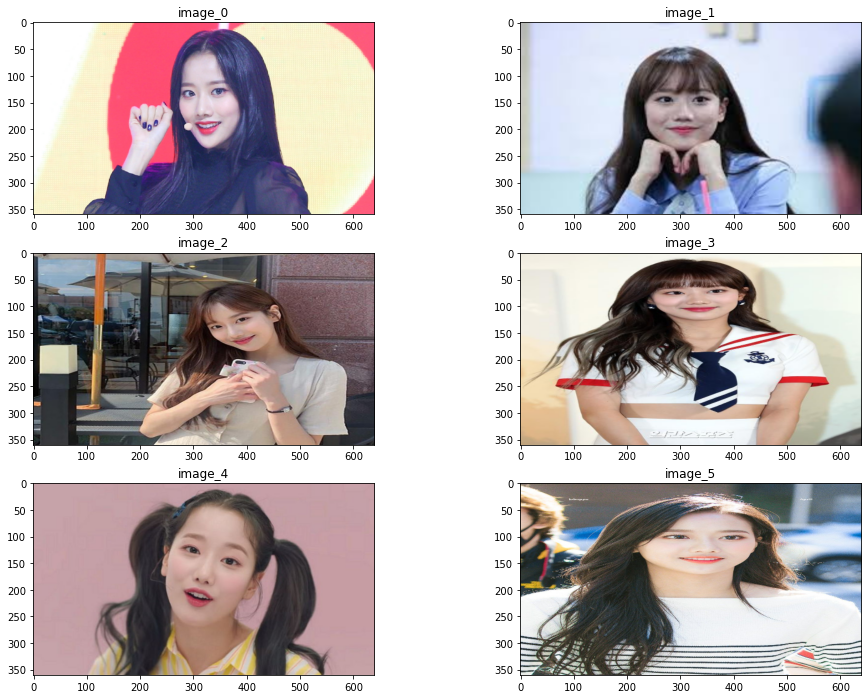

In [4]:
# rgb로 변환한 이미지들 6개 subplot 으로 나눠서 한 번에 보이기
NROWS_3 = 3
NCOLS_2 = 2
FIGSIZE_1612 = (16,12)
plotnbym(nrows =NROWS_3 , ncols =NCOLS_2, figsize = FIGSIZE_1612, imgs = images_rgb)

### 얼굴 검출

In [5]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # dlib을 활용해 hog detector 선언

In [6]:
# detector를 이용하여 얼굴의 bounding box 추출
dlib_rects_list = []
for img_rgb in images_rgb:
    dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
    dlib_rects_list.append(dlib_rects)

In [7]:
for rects in dlib_rects_list:
    print(rects)

rectangles[[(253, 96) (382, 225)]]
rectangles[[(239, 110) (368, 239)]]
rectangles[]
rectangles[]
rectangles[[(221, 77) (407, 263)]]
rectangles[]


3,4,6 번 이미지는 얼굴을 못 찾았다!
- 3번은 각도가 다르고
- 4,6번은 사진이 많이 왜곡되었기 때문으로 보인다.

얼굴을 찾은 이미지만 추린다.

In [8]:
rects_detected_list = []
for idx,rects in enumerate(dlib_rects_list):
    if(not not rects):
        rects_detected_list.append(
            {
                'idx' : idx,
                'rects' : rects
            }
        )

In [9]:
print(len(rects_detected_list))
rects_detected_list

3


[{'idx': 0, 'rects': rectangles[[(253, 96) (382, 225)]]},
 {'idx': 1, 'rects': rectangles[[(239, 110) (368, 239)]]},
 {'idx': 4, 'rects': rectangles[[(221, 77) (407, 263)]]}]

In [10]:
rected_images_show_rgb = []
for idx_rects in rects_detected_list:
    idx = idx_rects['idx']
    dlib_rects = idx_rects['rects']
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()
        # cv2.rectangle(images_show[idx], (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        print(idx)
        cv2.rectangle(images_show[idx], (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    img_show_rgb =  cv2.cvtColor(images_show[idx], cv2.COLOR_BGR2RGB)
    rected_images_show_rgb.append(img_show_rgb)     

0
1
4


일단 얼굴을 찾은 이미지만 대상!

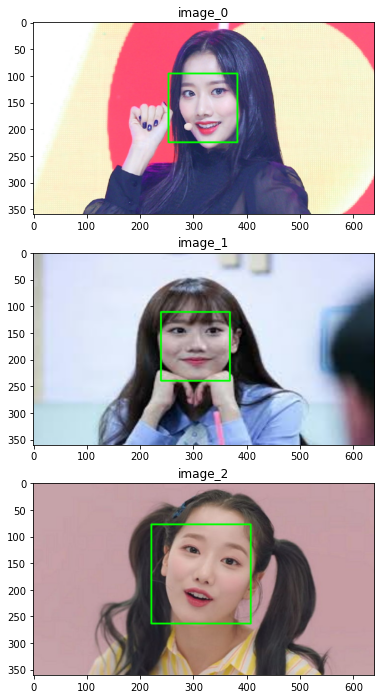

In [12]:
NCOLS_1 = 1
plotnbym(nrows =NROWS_3 , ncols =NCOLS_1, figsize = FIGSIZE_1612, imgs = rected_images_show_rgb)

## 스티커 적용 위치 확인하기
고양이 수염이 적용될 볼 위치를 landmark를 사용해서 계산해보기   
볼은 '턱' '눈' '입' '코' 사이에 있다! 비율로 계산!   
2,36,48,30 번 인덱스가 왼쪽 볼   
14,45,54,30 번 인덱스가 오른쪽 볼


### 랜드마크 모델 불러오기

In [13]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [14]:
list_landmarks = []
for idx_rects in rects_detected_list:
    idx = idx_rects['idx']
    rects = idx_rects['rects']
    for rect in rects:
        points = landmark_predictor(images_show[idx], rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(
            {
                'idx' : idx,
                'list_points' : list_points
            }
        )

for idx_points in list_landmarks:
    print(len(idx_points['list_points']))

68
68
68


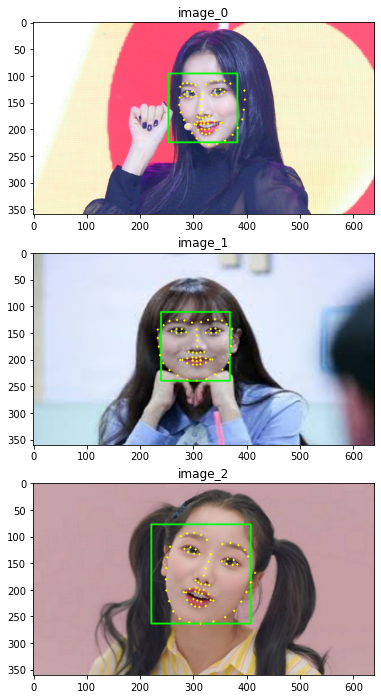

In [15]:
img_show_landmark_list = []
for idx_points in list_landmarks:
    idx = idx_points['idx']
    list_points = idx_points['list_points']
    for point in list_points:      
        cv2.circle(images_show[idx], point, 2, (0, 255, 255), -1) # yellow
    img_show_rgb = cv2.cvtColor(images_show[idx], cv2.COLOR_BGR2RGB)
    img_show_landmark_list.append(img_show_rgb)

plotnbym(nrows=NROWS_3,ncols=NCOLS_1,figsize=FIGSIZE_1612, imgs=img_show_landmark_list)

## 스티커 적용하기
1. 그냥 적용
2. 스티커 뒤로 원본 이미지가 같이 보이도록(반투명)
opencv의 cv2.addWeighted() 참조

In [16]:
nose_center_x_y_w_h = []
for idx_rects, idx_points in zip(rects_detected_list,list_landmarks):

    # print(idx_rects)
    # print(idx_points)
    # for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    idx = idx_rects['idx']
    rects = idx_rects['rects']
    list_points = idx_points['list_points']

    print (list_points[30]) # nose center index : 30
    for rect in rects:

        x = list_points[30][0]

        ## ========= 여기 y 값 계산이 중요함! ========= //

        # y = list_points[30][1] - rect.width()//2

        # 코 아래로 오게 하려면, 마이너스가 아니라 플러스를 해야함.

        # 이만큼은 부족함.
        # y = list_points[30][1] + rect.width()//3

        # 이만큼이 적당해보인다.
        y = list_points[30][1] + rect.width()//2

        ## ========= 여기 y 값 계산이 중요함! ========= //

        w = rect.width()
        h = rect.width()
        
        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))
        nose_center_x_y_w_h.append(
            {
                'idx' : idx,
                'nose_center' : list_points[30],
                'x_y' : (x,y),
                'w_h' : (w,h),
                'refined_x' : 0,
                'refined_y' : 0,
                'img_sticker' : [],
            }
        )
    

(313, 169)
(x,y) : (313,234)
(w,h) : (130,130)
(307, 175)
(x,y) : (307,240)
(w,h) : (130,130)
(319, 173)
(x,y) : (319,266)
(w,h) : (187,187)


(130, 130, 3)
(130, 130, 3)
(187, 187, 3)


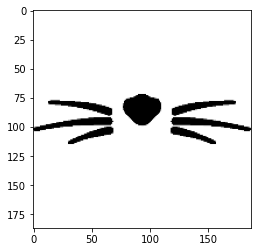

In [17]:
# 스티커 읽어오기
sticker_path = os.getenv('HOME')+'/Desktop/2020_aiffel/daily_notes/exploration_codes/e10_code/images/cat-whiskers.png'

# sticker_path_2 = os.getenv('HOME')+'/Desktop/2020_aiffel/daily_notes/exploration_codes/e10_code/images/hero.png'

img_sticker = cv2.imread(sticker_path)
# img_sticker_2 = cv2.imread(sticker_path_2)
# plotnbym(nrows=2,ncols=1,figsize=FIGSIZE_1612,imgs=[img_sticker,img_sticker_2])

for point in nose_center_x_y_w_h:
    idx = point['idx']
    w_h = point['w_h']
    temp = cv2.resize(img_sticker, w_h)

    point['img_sticker'] = temp    
    print(temp.shape)
    plt.imshow(temp)

   

### 스티커 이미지 추가를 위해 x,y 좌표를 조정!

In [18]:

for point in nose_center_x_y_w_h:
    x_y = point['x_y']
    w_h = point['w_h']
    x = x_y[0]
    y = x_y[1]
    w = w_h[0]
    h = w_h[1]

    refined_x = x - w // 2  # left
    refined_y = y - h       # top

    point['refined_x'] = refined_x
    point['refined_y'] = refined_y
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (248,104)
(x,y) : (242,110)
(x,y) : (226,79)


### 음수 제거 필요없음

In [19]:
imgs_rgb_with_sticker = []
for points in nose_center_x_y_w_h:
    idx = points['idx']
    img_show = images_show[idx]
    
    # plt.imshow(img_rgb)

    img_sticker = points['img_sticker']
    refined_x = points['refined_x']
    refined_y = points['refined_y']

    # print(img_sticker.shape)   
    # print(refined_x,refined_y) 
    
    # 음수제거 했을 때는 refiend_y 값에서 img_sticker x 길이만큼 이 범위였지만,
    # 음수제거 안한 상태니까 refined_y 값에서 refined_y+ x길이만큼이 범위임. 

    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    # print(sticker_area.shape)
    
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    imgs_rgb_with_sticker.append(img_show_rgb)

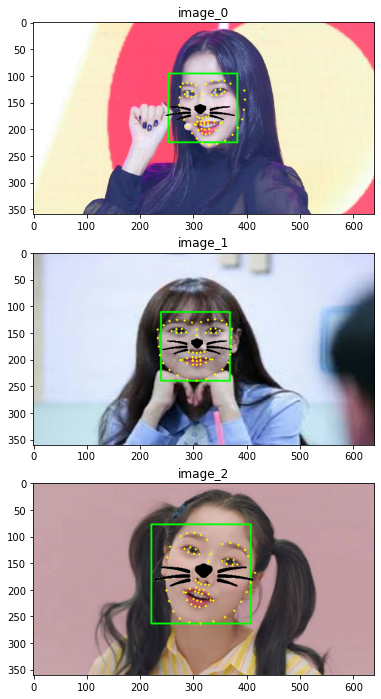

In [20]:
plotnbym(nrows=NROWS_3,ncols=NCOLS_1,figsize=FIGSIZE_1612,imgs=imgs_rgb_with_sticker)

### bounding box 와 landmark 제거하고 최종 결과만 출력

In [21]:
imgs_final_rgb = []
for points in nose_center_x_y_w_h:
    idx = points['idx']
    img_bgr = images_bgr[idx]
    
    # plt.imshow(img_rgb)

    img_sticker = points['img_sticker']
    refined_x = points['refined_x']
    refined_y = points['refined_y']

    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    img_bgr_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    imgs_final_rgb.append(img_bgr_rgb)

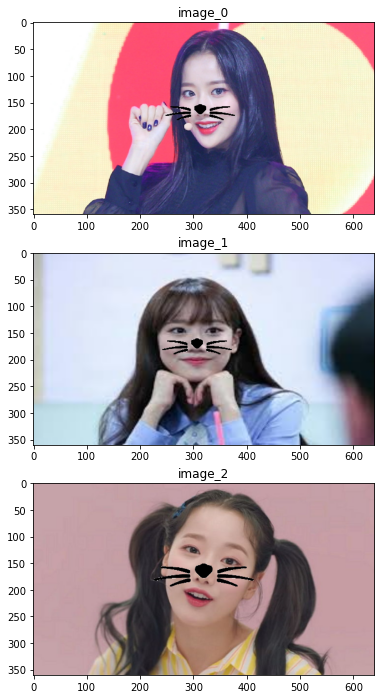

In [22]:
plotnbym(nrows=NROWS_3,ncols=NCOLS_1,figsize=FIGSIZE_1612,imgs=imgs_final_rgb)

### 반투명 스티커는 하다가 pass

## 문제점 찾아보기
1. 다양한 각도의 이미지에 스티커를 반복 적용해보기
2. 문제점이 무엇인지 기록해보기

=> 결과보고서에 기록

# 결과보고서

준비한 6개의 이미지 중, 얼굴 인식 (랜드마크) 에 성공한 이미지 3장에 대하여 과제를 수행해보았다.

### 인식되지 않는 이미지
준비한 이미지 중 총 세 장이 인식이 되지 않았다.
원래 이미지의 크기를 고려하지 않고 640x360 으로 일괄적으로 사이즈를 조정하면서 얼굴 이미지가 왜곡되어서 발생한 일이라고 생각한다.

### 각도
사실, 얼굴이 정면을 바라보고 있는 경우(코가 직선으로 내려오는 경우) 에는 문제없이 코가 자연스럽게 자리했다. 하지만, 마지막 이미지처럼 고개를 조금 기울인 상태에서는 그 각도에 맞춰 수염도 조금 돌아가는 것이 더 자연스러웠을텐데, 그정도는 하지 못했다.

아마, 코, 턱, 눈끝의 위치를 기반으로 두 볼의 중앙을 감지하고 감지한 두 볼 중앙간의 각도를 통해 수염 이미지의 각도를 변형시키는 것이 가능할 것으로 보인다.

### 결론
부족한 부분, 보완하고 싶은 부분들이 많지만, 그래도 인식하기 쉬운 경우(정면, 사진 왜곡되지 않음)에 한해서라도 성공적으로 과제를 수행한 점이 뿌듯하고 과정과 결과가 매우 흥미로웠다.


